# Discontinuity analysis and spectral mixture kerels


In [ ]:
!pip install git+ssh://git@github.com/UncertaintyInComplexSystems/bayesianmodels.git
!pip install numpy==1.23.5

In [12]:
import matplotlib.pyplot as plt

import jax
import jax.random as jrnd
import jax.numpy as jnp
import distrax as dx
import jaxkern as jk

from jax.config import config
config.update("jax_enable_x64", True)  # crucial for Gaussian processes
config.update("jax_default_device", jax.devices()[0])

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

from uicsmodels.gpmodels.fullgpmodels import FullLatentGPModel, FullMarginalGPModel
from uicsmodels.gpmodels.kernels import Discontinuous, SpectralMixture

## Discontinuity analysis

In [4]:
def disc_plot(ax, x, y, x0, *args, **kwargs):
    if jnp.ndim(y) == 1:
        y = y[:, jnp.newaxis]
    if jnp.ndim(x) == 1:
        x = x[:, jnp.newaxis]
    ix_pre = x[:, 0] < x0
    ix_post = x[:, 0] >= x0
    ax.plot(x[ix_pre, 0], y[ix_pre, 0], *args, **kwargs)
    ax.plot(x[ix_post, 0], y[ix_post, 0], *args, **kwargs)

#
def disc_fill_between(ax, x, y1, y2, x0, *args, **kwargs):
    if jnp.ndim(y1) == 1:
        y1 = y1[:, jnp.newaxis]
    if jnp.ndim(y2) == 1:
        y2 = y2[:, jnp.newaxis]
    if jnp.ndim(x) == 1:
        x = x[:, jnp.newaxis]
    ix_pre = x[:, 0] < x0
    ix_post = x[:, 0] >= x0
    ax.fill_between(x[ix_pre, 0], y1[ix_pre, 0], y2[ix_pre, 0], **kwargs)
    ax.fill_between(x[ix_post, 0], y1[ix_post, 0], y2[ix_post, 0], **kwargs)

#

Simulate some data from a known GP with a discontinuity at $x_0$:

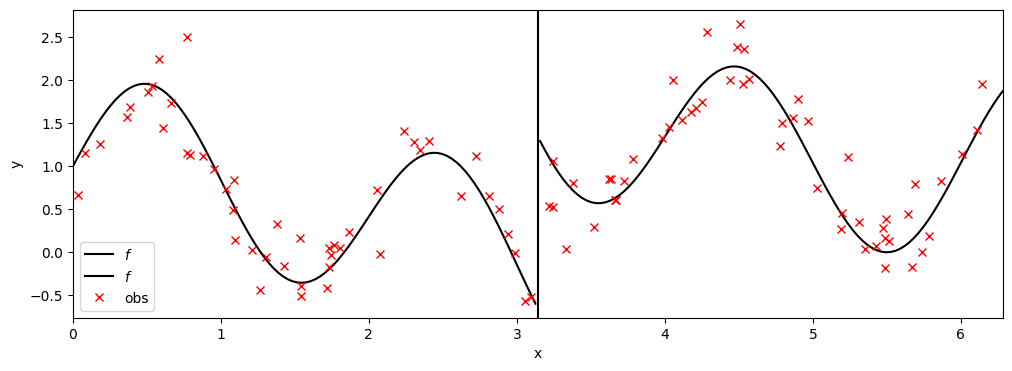

In [5]:
key = jrnd.PRNGKey(56)
key, key_x, key_y = jrnd.split(key, 3)

d = 2.0
f = lambda x, x0: jnp.sin(jnp.pi*x) + jnp.cos(4/7*x) + d*(x>=x0)
sigma = 0.3

x = jnp.linspace(0, 2*jnp.pi, num=200)
x0 = jnp.pi
n = 100

x_obs = 2*jnp.pi*jnp.sort(jrnd.uniform(key_x, shape=(n,)))
y = f(x_obs, x0) + sigma*jrnd.normal(key_y, shape=(n,))

plt.figure(figsize=(12, 4))
ax = plt.gca()
disc_plot(ax, x, f(x, x0), x0, 'k', label=r'$f$')
ax.plot(x_obs, y, 'rx', label='obs')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim([0., 2*jnp.pi])
ax.axvline(x=x0, c='k')
ax.legend(loc='best');

Set up the alternative model (with a discontinuity at $x_0$) $\mathcal{M}_1$:

In [6]:
%%time
priors = dict(kernel=dict(lengthscale=dx.Transformed(dx.Normal(loc=0.,
                                                               scale=1.),
                                                     tfb.Exp()),
                          variance=dx.Transformed(dx.Normal(loc=0.,
                                                            scale=1.),
                                                  tfb.Exp())),
              likelihood=dict(obs_noise=dx.Transformed(dx.Normal(loc=0.,
                                                                 scale=1.),
                                                       tfb.Exp())))

# We could set up a similar dict with step sizes and other MCMC parameters
gpdisc = FullMarginalGPModel(x_obs, y,
                         cov_fn=Discontinuous(base_kernel=jk.RBF(),
                                              x0=x0),
                         priors=priors)

key, key_smc = jrnd.split(key)
particles, num_iter, log_marginal_likelihood_disc = gpdisc.inference(key_smc,
                                                                     mode='smc',
                                                                     sampling_parameters=dict(num_particles=1_000, num_mcmc_steps=100))

CPU times: user 10.8 s, sys: 2.84 s, total: 13.7 s
Wall time: 22.4 s


Set up the null model (without a discontinuity) $\mathcal{M}_0$:

In [7]:
%%time
priors = dict(kernel=dict(lengthscale=dx.Transformed(dx.Normal(loc=0.,
                                                               scale=1.),
                                                     tfb.Exp()),
                          variance=dx.Transformed(dx.Normal(loc=0.,
                                                            scale=1.),
                                                  tfb.Exp())),
              likelihood=dict(obs_noise=dx.Transformed(dx.Normal(loc=0.,
                                                                 scale=1.),
                                                       tfb.Exp())))

# We could set up a similar dict with step sizes

gpcont = FullMarginalGPModel(x_obs, y,
                         cov_fn=jk.RBF(),
                         priors=priors)

key, key_smc = jrnd.split(key)
particles_cont, _, log_marginal_likelihood_cont = gpcont.inference(key_smc,
                                                                   mode='smc',
                                                                   sampling_parameters=dict(num_particles=1_000, num_mcmc_steps=50))

CPU times: user 6.93 s, sys: 1.27 s, total: 8.2 s
Wall time: 8.41 s


Plot the model fits and show the log Bayes factor of
$
    \log \text{BF}_{10} = \log \frac{p(D\mid \mathcal{M}_1)}{p(D\mid \mathcal{M}_0)} = \log p(D\mid \mathcal{M}_1) - \log p(D\mid \mathcal{M}_0) \enspace.
$

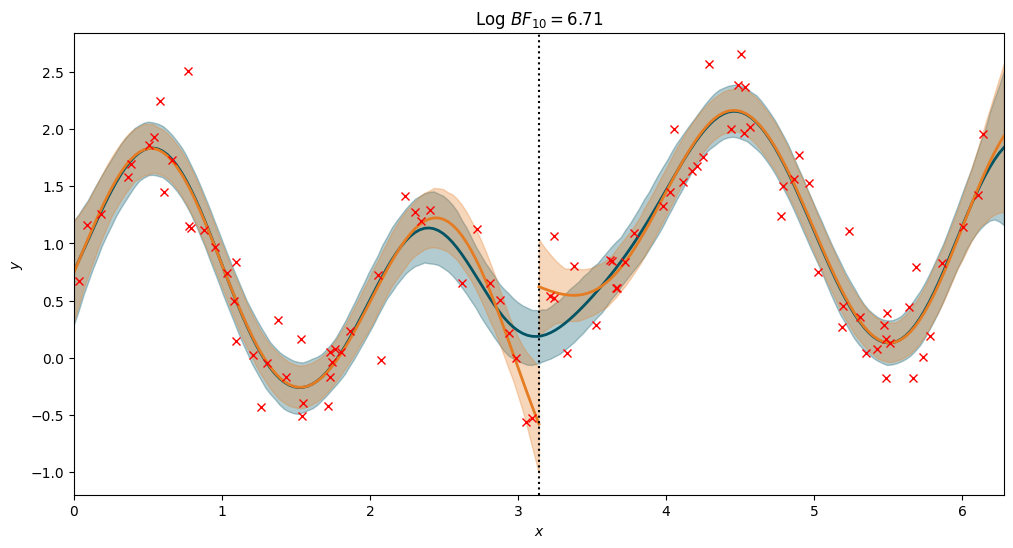

In [8]:
colors = ['#025464', '#E57C23']
labels = ['$\mathcal{M}_0$', '$\mathcal{M}_1$']

log_BF = log_marginal_likelihood_disc - log_marginal_likelihood_cont

key, key_cont, key_disc = jrnd.split(key, 3)
epsilon = 1e-6

x_pred = jnp.sort(jnp.append(jnp.linspace(0, 2*jnp.pi, 200), jnp.array([x0 - epsilon, x0 + epsilon])))

plt.figure(figsize=(12, 6))
ax = plt.gca()

post_pred = gpcont.predict_f(key_cont, x_pred=x_pred)
post_pred_mu = jnp.mean(post_pred, axis=0)
post_pred_hdi_lb, post_pred_hdi_ub = jnp.quantile(post_pred, axis=0,
                                                  q=jnp.array([0.025, 0.975]))
ax.plot(x_pred, post_pred_mu, color=colors[0], lw=2, label=labels[0])
ax.fill_between(jnp.squeeze(x_pred), post_pred_hdi_lb, post_pred_hdi_ub,
                    color=colors[0], alpha=0.3)

post_pred = gpdisc.predict_f(key_disc, x_pred=x_pred)
post_pred_mu = jnp.mean(post_pred, axis=0)
post_pred_hdi_lb, post_pred_hdi_ub = jnp.quantile(post_pred, axis=0,
                                                  q=jnp.array([0.025, 0.975]))

disc_plot(ax, x_pred, post_pred_mu, x0, color=colors[1], lw=2, label=labels[1])
disc_fill_between(ax, x_pred, post_pred_hdi_lb, post_pred_hdi_ub, x0,
                  color=colors[1], alpha=0.3)

ax.plot(x_obs, y, 'rx')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_xlim([0, 2*jnp.pi])
ax.axvline(x=x0, c='k', ls=':')
ax.set_title('Log $BF_{{10}}={:0.2f}$'.format(log_BF));

## GP regression with a spectral mixture kernel

The spectral mixture kernel is defined for $\tau = x-x'$ by
$$
k(\tau) = \sum_{q=1}^Q w_q \prod_{i=1}^D \exp \left[ -2\pi^2 \tau_i^2 v^{(i)}_q \right] \cos\left(2\pi \tau_i \mu_q^{(i)} \right) \enspace,
$$ with $Q$ the number of mixture components, $\mathbf{w}$ the weight vector, $\mathbf{\mu}$ the component means and $\mathbf{\nu}$ the covariances.

In typical marginal likelihood optimization of kernel hyperparameters, properly initializing the spectral mixture kernel parameters has a big impact on convergence time and estimation quality. With SMC, that appears to be a thing of the past; just by initializing from the prior we find excellent predictions.

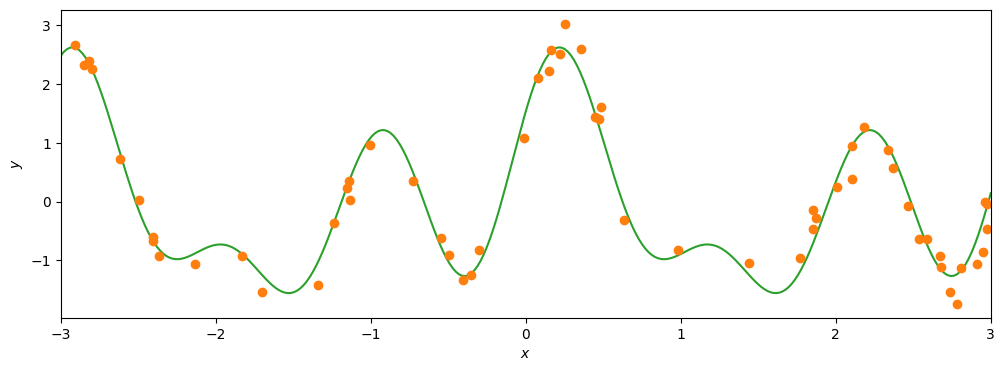

In [10]:
n = 60
noise = 0.2

key = jrnd.PRNGKey(12345)
key, key_x, key_obs = jrnd.split(key, 3)

x = jnp.sort(jrnd.uniform(key=key_x, minval=-3.0, maxval=3.0, shape=(n,))).reshape(-1, 1)
f = lambda x: jnp.sin(4 * x) + jnp.cos(2 * x) + jnp.sin(6 * (x - 2))
signal = f(x)
y = (signal + jrnd.normal(key_y, shape=signal.shape) * noise).flatten()

plt.figure(figsize=(12, 4))
plt.plot(jnp.linspace(-3, 3, num=300).reshape(-1, 1),
         f(jnp.linspace(-3, 3, num=300).reshape(-1, 1)),
         color='tab:green')
plt.plot(x, y, 'o', c='tab:orange')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.xlim([-3, 3]);

Set up the marginal GP model. Note that in our implementaton the number of components $Q$ is inferred from the prior. Furthermore, we use a centered softmax representation of the mixture weights, so that

$$
    \mathbf{w} = \text{softmax}([0, \mathbf{\beta}]) \enspace,
$$
where
$$
    \text{softmax}(\mathbf{x})_i = \frac{\exp(x_i)}{\sum_{j=1}^K \exp(x_j)} \enspace,
$$

with $K$ the length of vector $\mathbf{x}$.

In [13]:
%%time
Q = 3

priors = dict(kernel=dict(beta=dx.Normal(loc=jnp.zeros((Q-1,)),
                                         scale=jnp.ones((Q-1, ))),
                          mu=dx.Normal(loc=jnp.zeros((Q,)),
                                       scale=jnp.ones((Q,))),
                          nu=dx.Transformed(dx.Normal(loc=jnp.zeros((Q, )),
                                                      scale=jnp.ones((Q,))),
                                            tfb.Exp())),
              likelihood=dict(obs_noise=dx.Transformed(dx.Normal(loc=0.,
                                                                 scale=1.),
                                                       tfb.Exp())))

key, subkey = jrnd.split(key)

gp_smk = FullMarginalGPModel(x, y, cov_fn=SpectralMixture(), priors=priors)
smk_particles, _, smk_marginal_likelihood = gp_smk.inference(subkey,
                                                             mode='smc',
                                                             sampling_parameters=dict(num_particles=1_000,
                                                                                      num_mcmc_steps=100))

CPU times: user 8.29 s, sys: 1.24 s, total: 9.53 s
Wall time: 10.9 s


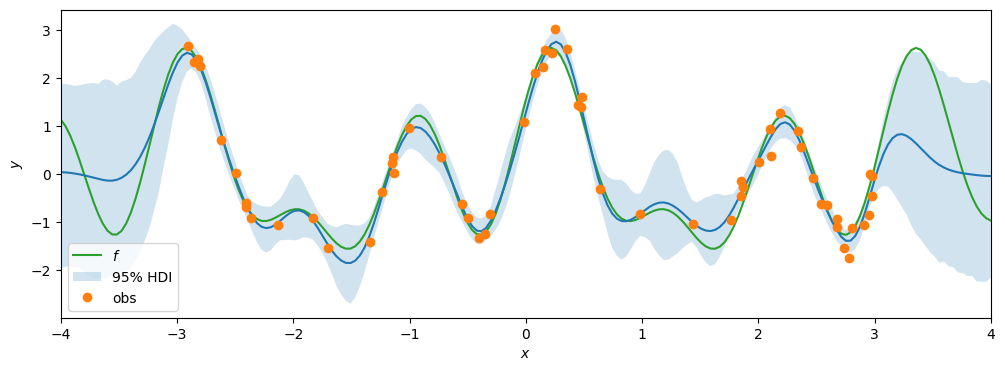

In [17]:
key, key_pred = jrnd.split(key)

xpred = jnp.linspace(-4, 4, num=200)[:, jnp.newaxis]

f_pred = gp_smk.predict_f(key_pred, xpred)

f_pred_mu = jnp.mean(f_pred, axis=0)
f_pred_hdi = jnp.quantile(f_pred, axis=0, q=jnp.array([0.025, 0.975]))

plt.figure(figsize=(12, 4))
plt.plot(xpred.reshape(-1, 1),
         f(xpred).reshape(-1, 1),
         color='tab:green', label=r'$f$')
plt.plot(xpred, f_pred_mu)
plt.fill_between(xpred.flatten(), f_pred_hdi[0], f_pred_hdi[1],
                 alpha=0.2, label='95% HDI')
plt.plot(x, y, 'o', label='obs')
plt.legend()
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.xlim([-4, 4]);